# Creating WASM ufuncs for `DataFrames` with `witxcraft` 

Import the `fromwasmmod` function from the  `witxcraft.ufunc` module. This function will read a WASM module and wrap the functions in it for use with `DataFrame/Series.apply` methods. 

In [1]:
import witxcraft as wc

The `fromwasmmod` function takes a filename or URL to a WASM module, or the raw contents of a WASM module. Either compiled WASM or WATX maybe used.

In [2]:
funcs = wc.fromwasmmod('df.wasm')

Generating "/tmp/tmp12e00kmt/bindings.py"


Using `dir` we can see the WASM functions that are available.

In [3]:
[x for x in dir(funcs) if not x.startswith('_')]

['mult', 'mult_vec', 'square', 'square_vec']

## Using WASM functions with pandas

To demonstrate WASM functions on `pandas` objects, we'll first load some data into a `DataFrame`.

In [4]:
import pandas as pd
import numpy as np

Generate some numeric data to work with.

In [5]:
data_len = 100000
df = pd.DataFrame(dict(X=np.random.randint(0, 50, size=data_len),
                       Y=np.random.randint(0, 50, size=data_len),
                       Z=np.random.randint(0, 50, size=data_len)))
df

,X,Y,Z
0,19,42,35
1,35,48,40
2,15,28,11
3,15,40,30
4,0,26,48
...,...,...,...
99995,38,2,32
99996,27,16,9
99997,19,22,1
99998,2,45,49


### Simple example of a WASM function with scalar input and output

The `square` function simply squares the given value.

In [6]:
funcs.square(10)

100

In [7]:
funcs.mult(10, 5)

50

In [8]:
funcs.square_vec([5, 10])

0     25
1    100
dtype: int64

In [9]:
funcs.mult_vec([5, 10], [2, 3])

0    10
1    30
dtype: int64

### Using the WASM functions with pandas data

This function can be applied to a `pandas.Series` using the `apply` method as follows.

In [10]:
%time df.X.apply(funcs.mult, args=[10])

CPU times: user 16.2 s, sys: 14.5 ms, total: 16.3 s
Wall time: 16.3 s


0        190
1        350
2        150
3        150
4          0
        ... 
99995    380
99996    270
99997    190
99998     20
99999    440
Name: X, Length: 100000, dtype: int64

Since the functions support the `ufunc` API, you can also apply them as a function call with the `pandas.Series` as the argument.

In [ ]:
%time funcs.mult(df.X, 10)

CPU times: user 2.14 s, sys: 0 ns, total: 2.14 s
Wall time: 2.13 s


0        130
1        290
2        380
3        370
4        210
        ... 
99995    410
99996     90
99997    130
99998    370
99999     50
Name: X, Length: 100000, dtype: object

Using the vector version of the `mult` func, we can send two `Series` objects in. Rather than allowing the `DataFrame` to iterate over the objects and apply a new function call on each pair, this version will push the data from both objects into the WASM memory and do all of the work in WASM. This eliminates much of the WASM call overhead.

### Using a vectorized WASM function with pandas data

Vector versions of the functions copy the entire data vector into WASM memory before operating on it. This reduces the WASM function call overhead.

In [ ]:
%time funcs.mult_vec(df.X, df.Y)

CPU times: user 57.3 ms, sys: 8.65 ms, total: 66 ms
Wall time: 60.7 ms


0         195
1         203
2        1254
3        1258
4        1008
         ... 
99995    1353
99996     153
99997      52
99998     851
99999      65
Length: 100000, dtype: int64

## Example with WITX record inputs and outputs

In this WASM module, we have several functions. We'll be using the `sentiment` function with calculates a sentiment value based on the content of a string. The code for this example comes from https://github.com/singlestore-labs/wasi-data-rust.

In [ ]:
ml = wc.fromwasmmod('example_wasm.wasm', witx='iface.witx')

Generating "/tmp/tmpqg722mbf/bindings.py"


List the functions in the module.

In [ ]:
[x for x in dir(ml) if not x.startswith('_')]

['sentiment']

### Running the `sentiment` WASM function on scalar values

Running the `sentiment` function on a string will return the sentiment scores. The initial lag of this function call is due to the fact that the WASM content is not compiled by the wasmtime engine until it is first needed. Subsequent calls will be much faster.

In [ ]:
ml.sentiment('Welcome home')

compound    0.458831
positive    0.750000
negative    0.000000
neutral     0.250000
dtype: float64

In [ ]:
ml.sentiment('This smells bad')

compound   -0.542326
positive    0.000000
negative    0.636364
neutral     0.363636
dtype: float64

Note that although we used a scalar value as input above, the WASM function actually takes a record as input (see ml.witx file). This record just happens to have a single field in it named 's' of type str.

### Using the `sentiment` WASM function with pandas

First, we'll load a data set of string values to be evaluated using the `sentiment` function. The data set used here was downloaded from http://jmcauley.ucsd.edu/data/amazon/ (see citations at the end).

In [ ]:
df = pd.read_csv('data/phones.csv', nrows=100)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
...,...,...,...,...,...,...,...,...,...
95,A16GNVT2QWNYPM,8288855504,Steve,"[0, 0]","It does what it needs to do, very pleased. I b...",5.0,Awesome,1313712000,"08 19, 2011"
96,A2VIMRVTUCKF9M,8288855504,zeppbiatch,"[1, 1]",Charger works great. Haven't had any issues wi...,4.0,great charger,1290729600,"11 26, 2010"
97,A1MMMVGC7A7P1Y,8288862993,alex,"[0, 0]",It works great thus far no issues. The only...,3.0,this is great buy and very useful,1397260800,"04 12, 2014"
98,A1WK0DH0W21F3G,8288862993,AndyC,"[0, 0]",The big store that is in every town now (can't...,5.0,It Works Great,1390176000,"01 20, 2014"


Here we are applying the `sentiment` function to a `Series`. Note that the output contains all of the same fields as the record described in the original WASM function. However, each output record is converted to a `Series` by the wrapper and a `DataFrame` with multiple columns is the result.

In [ ]:
out = df['reviewText'].apply(ml.sentiment)
out

,compound,positive,negative,neutral
0,-0.180808,0.140395,0.181836,0.677769
1,0.947132,0.387269,0.000000,0.612731
2,0.885161,0.237960,0.000000,0.762040
3,0.962457,0.313612,0.000000,0.686388
4,0.902009,0.356748,0.000000,0.643252
...,...,...,...,...
95,0.245068,0.145292,0.104489,0.750219
96,0.898994,0.332406,0.000000,0.667594
97,0.411765,0.223114,0.199037,0.577849
98,0.945759,0.112612,0.009455,0.877933


You can also apply the function where the `Series` is the argument to the function.

In [ ]:
ml.sentiment(df['reviewText'])

,compound,positive,negative,neutral
0,-0.180808,0.140395,0.181836,0.677769
1,0.947132,0.387269,0.000000,0.612731
2,0.885161,0.237960,0.000000,0.762040
3,0.962457,0.313612,0.000000,0.686388
4,0.902009,0.356748,0.000000,0.643252
...,...,...,...,...
95,0.245068,0.145292,0.104489,0.750219
96,0.898994,0.332406,0.000000,0.667594
97,0.411765,0.223114,0.199037,0.577849
98,0.945759,0.112612,0.009455,0.877933


It is also possible to apply the function to multiple columns from a `DataFrame` as long as they are all the correct data type. In this case, the values returned for each row are `Series` objects stored in a `DataFrame`.

In [ ]:
out = ml.sentiment(df[['reviewText', 'reviewerName']])
out

,reviewText,reviewerName
0,compound -0.180808 positive 0.140395 nega...,compound 0.0 positive 0.0 negative 0....
1,compound 0.947132 positive 0.387269 nega...,compound 0.0 positive 0.0 negative 0....
2,compound 0.885161 positive 0.237960 nega...,compound 0.0 positive 0.0 negative 0....
3,compound 0.962457 positive 0.313612 nega...,compound 0.0 positive 0.0 negative 0....
4,compound 0.902009 positive 0.356748 nega...,compound 0.0 positive 0.0 negative 0....
...,...,...
95,compound 0.245068 positive 0.145292 nega...,compound 0.0 positive 0.0 negative 0....
96,compound 0.898994 positive 0.332406 nega...,compound 0.0 positive 0.0 negative 0....
97,compound 0.411765 positive 0.223114 nega...,compound 0.0 positive 0.0 negative 0....
98,compound 0.945759 positive 0.112612 nega...,compound 0.0 positive 0.0 negative 0....


Pulling out a single value, we see that each element contains a `Series` object.

In [ ]:
type(out['reviewText'].iloc[0])

pandas.core.series.Series

Using the strings from the original data set and the `pd.concat` function, we can join the sentiment scores with the original text values.

In [ ]:
pd.concat([df['reviewText'], pd.DataFrame(list(out['reviewText']))], axis=1)

,reviewText,compound,positive,negative,neutral
0,They look good and stick good! I just don't li...,-0.180808,0.140395,0.181836,0.677769
1,These stickers work like the review says they ...,0.947132,0.387269,0.000000,0.612731
2,These are awesome and make my phone look so st...,0.885161,0.237960,0.000000,0.762040
3,Item arrived in great time and was in perfect ...,0.962457,0.313612,0.000000,0.686388
4,"awesome! stays on, and looks great. can be use...",0.902009,0.356748,0.000000,0.643252
...,...,...,...,...,...
95,"It does what it needs to do, very pleased. I b...",0.245068,0.145292,0.104489,0.750219
96,Charger works great. Haven't had any issues wi...,0.898994,0.332406,0.000000,0.667594
97,It works great thus far no issues. The only...,0.411765,0.223114,0.199037,0.577849
98,The big store that is in every town now (can't...,0.945759,0.112612,0.009455,0.877933


### Using the `sentiment` WASM function with Dask

It is also possible to use the `sentiment` function in a distributed environment such as a Dask `DataFrame`. We will set up a cluster of workers on our local machine to demonstrate. Demonstrating a true distributed cluster with multiple machines is beyond the scope of this demo, however, as long as the same Python modules exist on all machines, the function will be able to run in all worker nodes.

In [ ]:
from dask.distributed import Client

In [ ]:
client = Client()
client.cluster

distributed.diskutils - INFO - Found stale lock file and directory '/workspaces/wasi-data-python/examples/dask-worker-space/worker-5pj58yiu', purging
distributed.diskutils - INFO - Found stale lock file and directory '/workspaces/wasi-data-python/examples/dask-worker-space/worker-ixjvt27w', purging
distributed.diskutils - INFO - Found stale lock file and directory '/workspaces/wasi-data-python/examples/dask-worker-space/worker-lz2_6zft', purging
distributed.diskutils - INFO - Found stale lock file and directory '/workspaces/wasi-data-python/examples/dask-worker-space/worker-wbyiitia', purging


LocalCluster(4f9fadd6, 'tcp://127.0.0.1:41679', workers=4, threads=4, memory=1.94 GiB)

We'll use the same data set as above and simply partition it using Dask.

In [ ]:
import dask.dataframe as dd

# Read data set
daskdf = dd.read_csv('data/phones.csv', dtype='object')

# Make sure we have multiple partitions.
daskdf = daskdf.repartition(3)

daskdf

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
npartitions=3,,,,,,,,,
,object,object,object,object,object,object,object,object,object
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


We can now applly the `sentiment` function to a Dask `Series` as well. Note that Dask reccomends supplying the explicit output data types for a function. Otherwise, it will have to run the function on a set of sample data to determine the data types. The `sentiment` function has a `ret_meta` attribute that supplies that information.

In [ ]:
len(daskdf)

9999

Apply the `sentiment` function to the `reviewText` column of the Dask `DataFrame`. The function will be pickled and sent to each of the workers to be unpickled and initialized in a fresh WASM instance on that worker node. Until we call `.compute()` on the result, the operation is simply added to a graph of operations.

Note that the Dask `DataFrame.apply` method takes a `meta=` field. If this is not supplied, Dask will attempt to run the function with sample data to guess the output type. Using the `meta=` parameter allows you to skip that step and tell Dask explicitly what the output type is. Each WASM function supplies the return type metadata in the `ret_meta` attribute.

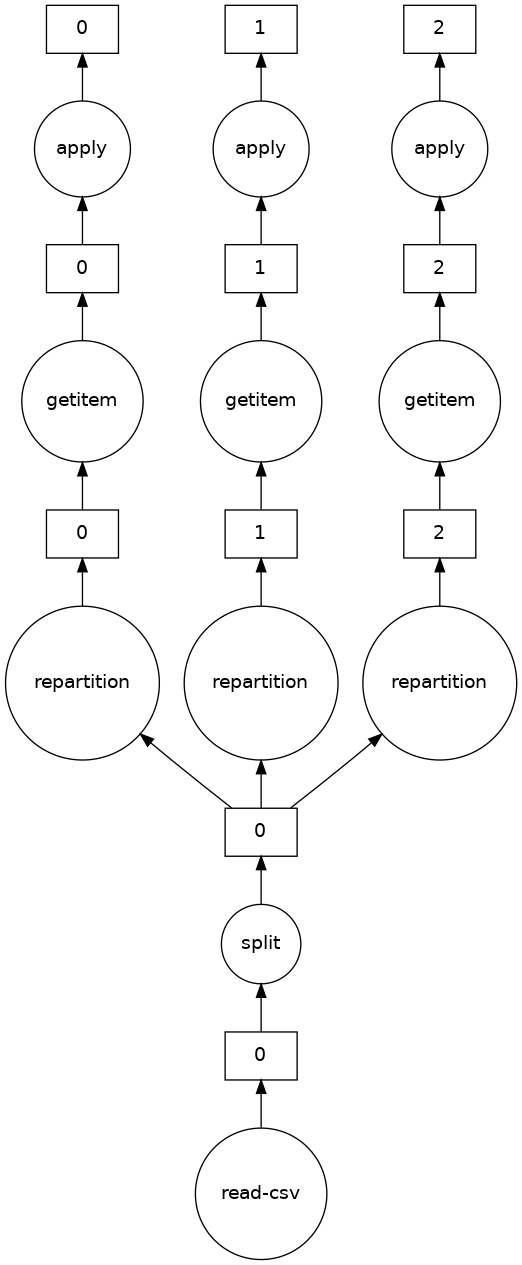

In [ ]:
out = daskdf['reviewText'].apply(ml.sentiment, meta=ml.sentiment.ret_meta)
out.visualize()

Execute all pending operations, including running the `sentiment` function.

In [ ]:
%time out.compute()

CPU times: user 336 ms, sys: 152 ms, total: 488 ms
Wall time: 7.55 s


,compound,positive,negative,neutral
0,-0.180808,0.140395,0.181836,0.677769
1,0.947132,0.387269,0.000000,0.612731
2,0.885161,0.237960,0.000000,0.762040
3,0.962457,0.313612,0.000000,0.686388
4,0.902009,0.356748,0.000000,0.643252
...,...,...,...,...
9994,0.970301,0.106962,0.034075,0.858963
9995,0.957716,0.187080,0.061388,0.751533
9996,0.101208,0.200230,0.184057,0.615713
9997,0.992833,0.166485,0.043013,0.790502


Shut the Dask cluster down.

In [ ]:
client.close()

## Citations for data set

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

WWW, 2016

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

SIGIR, 2015